In [2]:
import glob, sys
sys.path.append("../src")
from utils_io import read_json
from utils import bullet_processor

import pandas as pd
import numpy as np
import glob, json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
from collections import defaultdict
from matplotlib.ticker import MultipleLocator, PercentFormatter

# Put at top of plotting script (requires tex be installed though)
matplotlib.rc('font', family='serif')
# matplotlib.rc('text', usetex=True)

#matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=sns.color_palette("colorblind"))

FULL_WIDTH = 6.75133
COL_WIDTH  = 3.25063


def adjust(fig, left=0.0, right=1.0, bottom=0.0, top=1.0, wspace=0.0, hspace=0.0):
    fig.subplots_adjust(
        left   = left,  # the left side of the subplots of the figure
        right  = right,  # the right side of the subplots of the figure
        bottom = bottom,  # the bottom of the subplots of the figure
        top    = top,  # the top of the subplots of the figure
        wspace = wspace,  # the amount of width reserved for blank space between subplots
        hspace = hspace,  # the amount of height reserved for white space between subplots
    )

def remove_axes(ax):
    ax.spines[['right', 'top']].set_visible(False)


def save_fig(fig, name, dpi=200, base_dir="../paper/images", **kwargs):
    import os
    path = f"{base_dir}/{name}"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print(f"Image saved in {path}")
    fig.savefig(path, dpi=dpi, bbox_inches='tight', **kwargs)


COMBINATIONS = (2, 3, 4, 5)
MODELS = (
    "gpt-4o-2024-05-13",
    "gpt-3.5-turbo-0125",
    "accounts/fireworks/models/llama-v3-70b-instruct",
    "accounts/fireworks/models/mixtral-8x7b-instruct-hf",
    # "accounts/fireworks/models/llama-v3p1-70b-instruct",
)

### Summaries Analysis: Length

In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, RegexpTokenizer
regex_tokenize = RegexpTokenizer(r'\w+').tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catarinabelem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Ground truth

In [11]:
def get_number_of_words_ground_truth(ground_truth_insights: list, insights: dict):
    total_str = []
    for uuid in ground_truth_insights:
        total_str += ["- " + insights[uuid]["insight"]]
    
    total_str = "\n".join(total_str)
    return total_str 

In [12]:
ground_length_analysis = defaultdict(list)
for combination in COMBINATIONS:
    filepaths = glob.glob(f'../data/SummHay/preprocessed/some_shared/combinations-{combination}/topic_news*__300.json', recursive=True)
    
    for fp in sorted(filepaths):        
        data = read_json(fp)
        insights = data["insights"]
        for assign in data["assignments"]:
            ground_length_analysis["fp"].append(fp)
            ground_length_analysis["num_docs"].append(combination)

            gold_insight = get_number_of_words_ground_truth(assign["ground_truth_insights_uuids"], insights)
            ground_length_analysis["nltk_num_words"].append(len(word_tokenize(gold_insight)))
            ground_length_analysis["nltk_num_words_no_punct"].append(len(regex_tokenize(gold_insight)))
            ground_length_analysis["type"].append("shared")
            ground_length_analysis["num_insights"].append(len(assign["ground_truth_insights_uuids"]))

            # Determine the length of the insights related to a given subtopic
            ground_length_analysis["fp"].append(fp)
            ground_length_analysis["num_docs"].append(combination)

            
            all_uuids = assign["all_insights_uuids"]
            all_uuids_of_subtopic = [uuid for uuid in all_uuids if insights[uuid]["subtopic_id"] == assign["subtopic_uuid"]]

            gold_insight = get_number_of_words_ground_truth(all_uuids_of_subtopic, insights)
            ground_length_analysis["nltk_num_words"].append(len(word_tokenize(gold_insight)))
            ground_length_analysis["nltk_num_words_no_punct"].append(len(regex_tokenize(gold_insight)))
            ground_length_analysis["type"].append("any")
            ground_length_analysis["num_insights"].append(len(all_uuids_of_subtopic))

ground_length_analysis = pd.DataFrame(ground_length_analysis)
ground_length_analysis.groupby(["type", "num_docs"]).count()

fp  nltk_num_words  nltk_num_words_no_punct  num_insights
type   num_docs                                                             
any    2         1500            1500                     1500          1500
       3         1500            1500                     1500          1500
       4         1500            1500                     1500          1500
       5         1500            1500                     1500          1500
shared 2         1500            1500                     1500          1500
       3         1500            1500                     1500          1500
       4         1500            1500                     1500          1500
       5         1500            1500                     1500          1500

Image saved in ../paper/images/histplot/dataset__avg_num_words_with_punct.pdf


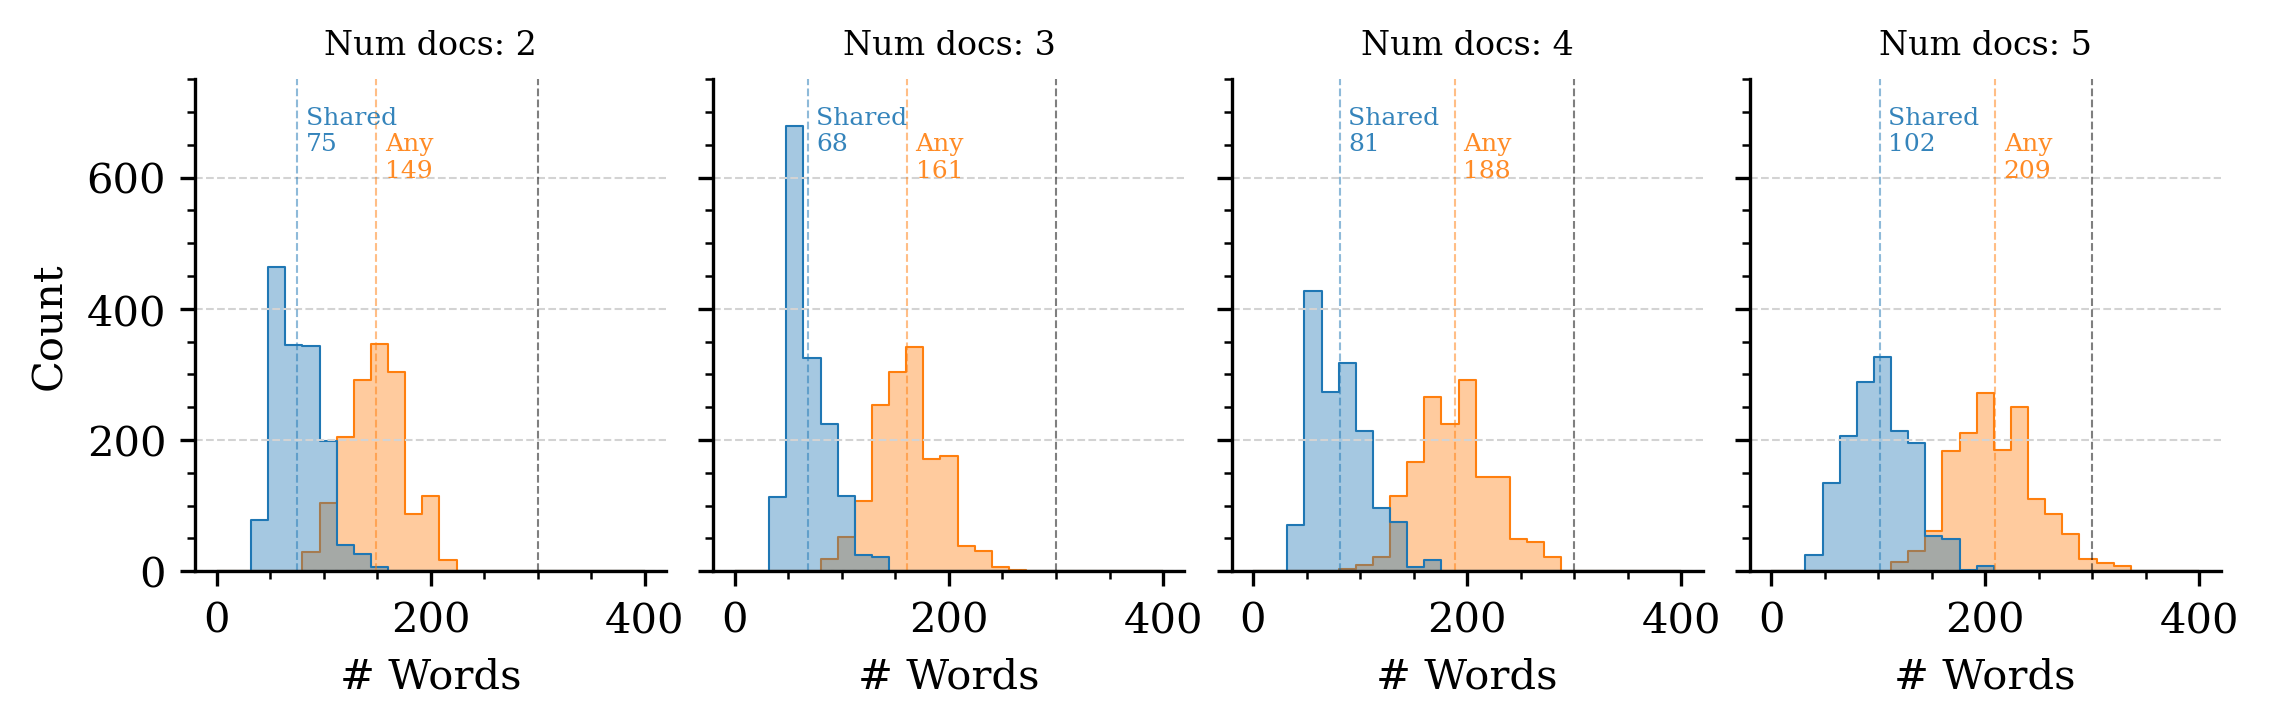

In [13]:
metric = "nltk_num_words"
fig, axes = plt.subplots(1, len(COMBINATIONS), sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)
# fig.suptitle("Ground truth distribution (data)", fontsize=8)

for i, comb in enumerate(COMBINATIONS):
    length_comb_subset = ground_length_analysis[ground_length_analysis["num_docs"] == comb]
    sns.histplot(length_comb_subset, x=metric, ax=axes[i], hue="type", bins=25, binrange=(0, 400), element="step", fill=True, linewidth=0.5, alpha=0.4)
    axes[i].set_title(f"Num docs: {comb}", fontsize=8)
    axes[i].set_xlabel("# Words")
    axes[i].set_ylim((0, 750))

    axes[i].xaxis.set_minor_locator(MultipleLocator(50))
    axes[i].xaxis.set_major_locator(MultipleLocator(200))
    axes[i].yaxis.set_minor_locator(MultipleLocator(50))
    axes[i].yaxis.set_major_locator(MultipleLocator(200))

    axes[i].grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
#    axes[i].grid(axis='y', which="minor", linewidth=0.5, linestyle=':', color="lightgray")

    length_subset_shared_mean = length_comb_subset.loc[length_comb_subset["type"] == "shared", metric].mean()
    length_subset_any_mean = length_comb_subset.loc[length_comb_subset["type"] == "any", metric].mean()
    colors = sns.color_palette("tab10")[:2]
    
    axes[i].axvline(x=length_subset_shared_mean, color=colors[0], linewidth=0.5, linestyle='--', alpha=0.5)
    axes[i].axvline(x=length_subset_any_mean, color=colors[1], linewidth=0.5, linestyle='--', alpha=0.5)

    axes[i].axvline(x=300, color="black", linewidth=0.5, linestyle='--', alpha=0.5)

    axes[i].annotate(f'Shared \n{length_subset_shared_mean:.0f}', xy=(length_subset_shared_mean, 570), xytext=(2, 10),
                 textcoords='offset points', ha='left', va='bottom', fontsize=6, color=colors[0], alpha=0.9)
    
    axes[i].annotate(f'Any \n{length_subset_any_mean:.0f}', xy=(length_subset_any_mean, 530), xytext=(2, 10),
                 textcoords='offset points', ha='left', va='bottom', fontsize=6, color=colors[1], alpha=0.9)
    remove_axes(axes[i])
    axes[i].get_legend().remove()


adjust(fig, top=0.82, wspace=0.1)
save_fig(fig, "histplot/dataset__avg_num_words_with_punct.pdf")

#### Models (using condition of 300 words)

In [14]:
length_analysis = defaultdict(list)
for combination in COMBINATIONS:
    for model in MODELS:
        for prompt_type in ("subtopic", "subtopic_trustworthy"):
            filepaths = glob.glob(f'../outputs_length300/results_some_shared/{prompt_type}/SummHay__combinations-{combination}/{model}/topic_news*__300__examples0,50.json', recursive=True)
            for fp in sorted(filepaths):        
                data = read_json(fp)
                for assign in data["assignments"]:
                    length_analysis["fp"].append(fp)
                    length_analysis["model"].append(model.rpartition("/")[-1])
                    if prompt_type == "subtopic":
                        length_analysis["type"].append("any")
                    else:
                        length_analysis["type"].append("shared")
                    length_analysis["num_docs"].append(combination)
                    length_analysis["nltk_num_words"].append(len(word_tokenize(assign["response"])))
                    length_analysis["nltk_num_words_no_punct"].append(len(regex_tokenize(assign["response"])))
                    length_analysis["num_insights"].append(len(bullet_processor(assign["response"])))

length_analysis = pd.DataFrame(length_analysis)
length_analysis.groupby(["num_docs", "type"]).count()

fp  model  nltk_num_words  nltk_num_words_no_punct  \
num_docs type                                                          
2        any     500    500             500                      500   
         shared  500    500             500                      500   
3        any     500    500             500                      500   
         shared  500    500             500                      500   
4        any     500    500             500                      500   
         shared  500    500             500                      500   
5        any     500    500             500                      500   
         shared  500    500             500                      500   

                 num_insights  
num_docs type                  
2        any              500  
         shared           500  
3        any              500  
         shared           500  
4        any              500  
         shared           500  
5        any              500  
         shared           500

## Models w/o condition on the number of words

In [15]:
MODELS = (
    "gpt-4o-2024-05-13",
    "gpt-3.5-turbo-0125",
    # "accounts/fireworks/models/llama-v3-70b-instruct",
    "accounts/fireworks/models/llama-v3p1-70b-instruct",
    "accounts/fireworks/models/qwen2-72b-instruct",
    #"accounts/fireworks/models/llama-v3p1-8b-instruct",
    # "accounts/fireworks/models/gemma2-9b-it",
)

In [16]:
length_analysis = defaultdict(list)
for combination in COMBINATIONS:
    for model in MODELS:
        for prompt_type in ("subtopic", "subtopic_trustworthy"):
            filepaths = glob.glob(f'../outputs/generate_summaries/results_some_shared/{prompt_type}/SummHay__combinations-{combination}/{model}/topic_news*__300__examples0,100.json', recursive=True)
            for fp in sorted(filepaths):        
                data = read_json(fp)
                for assign in data["assignments"]:
                    length_analysis["fp"].append(fp)
                    length_analysis["model"].append(model.rpartition("/")[-1])
                    if prompt_type == "subtopic":
                        length_analysis["type"].append("any")
                    else:
                        length_analysis["type"].append("shared")
                    length_analysis["num_docs"].append(combination)
                    length_analysis["nltk_num_words"].append(len(word_tokenize(assign["response"])))
                    length_analysis["nltk_num_words_no_punct"].append(len(regex_tokenize(assign["response"])))
                    length_analysis["num_insights"].append(len(bullet_processor(assign["response"])))

length_analysis = pd.DataFrame(length_analysis)
length_analysis.groupby(["num_docs", "type"]).count()

fp  model  nltk_num_words  nltk_num_words_no_punct  \
num_docs type                                                           
2        any     2000   2000            2000                     2000   
         shared  2000   2000            2000                     2000   
3        any     2000   2000            2000                     2000   
         shared  2000   2000            2000                     2000   
4        any     2000   2000            2000                     2000   
         shared  2000   2000            2000                     2000   
5        any     2000   2000            2000                     2000   
         shared  2000   2000            2000                     2000   

                 num_insights  
num_docs type                  
2        any             2000  
         shared          2000  
3        any             2000  
         shared          2000  
4        any             2000  
         shared          2000  
5        any             2000  
         shared          2000

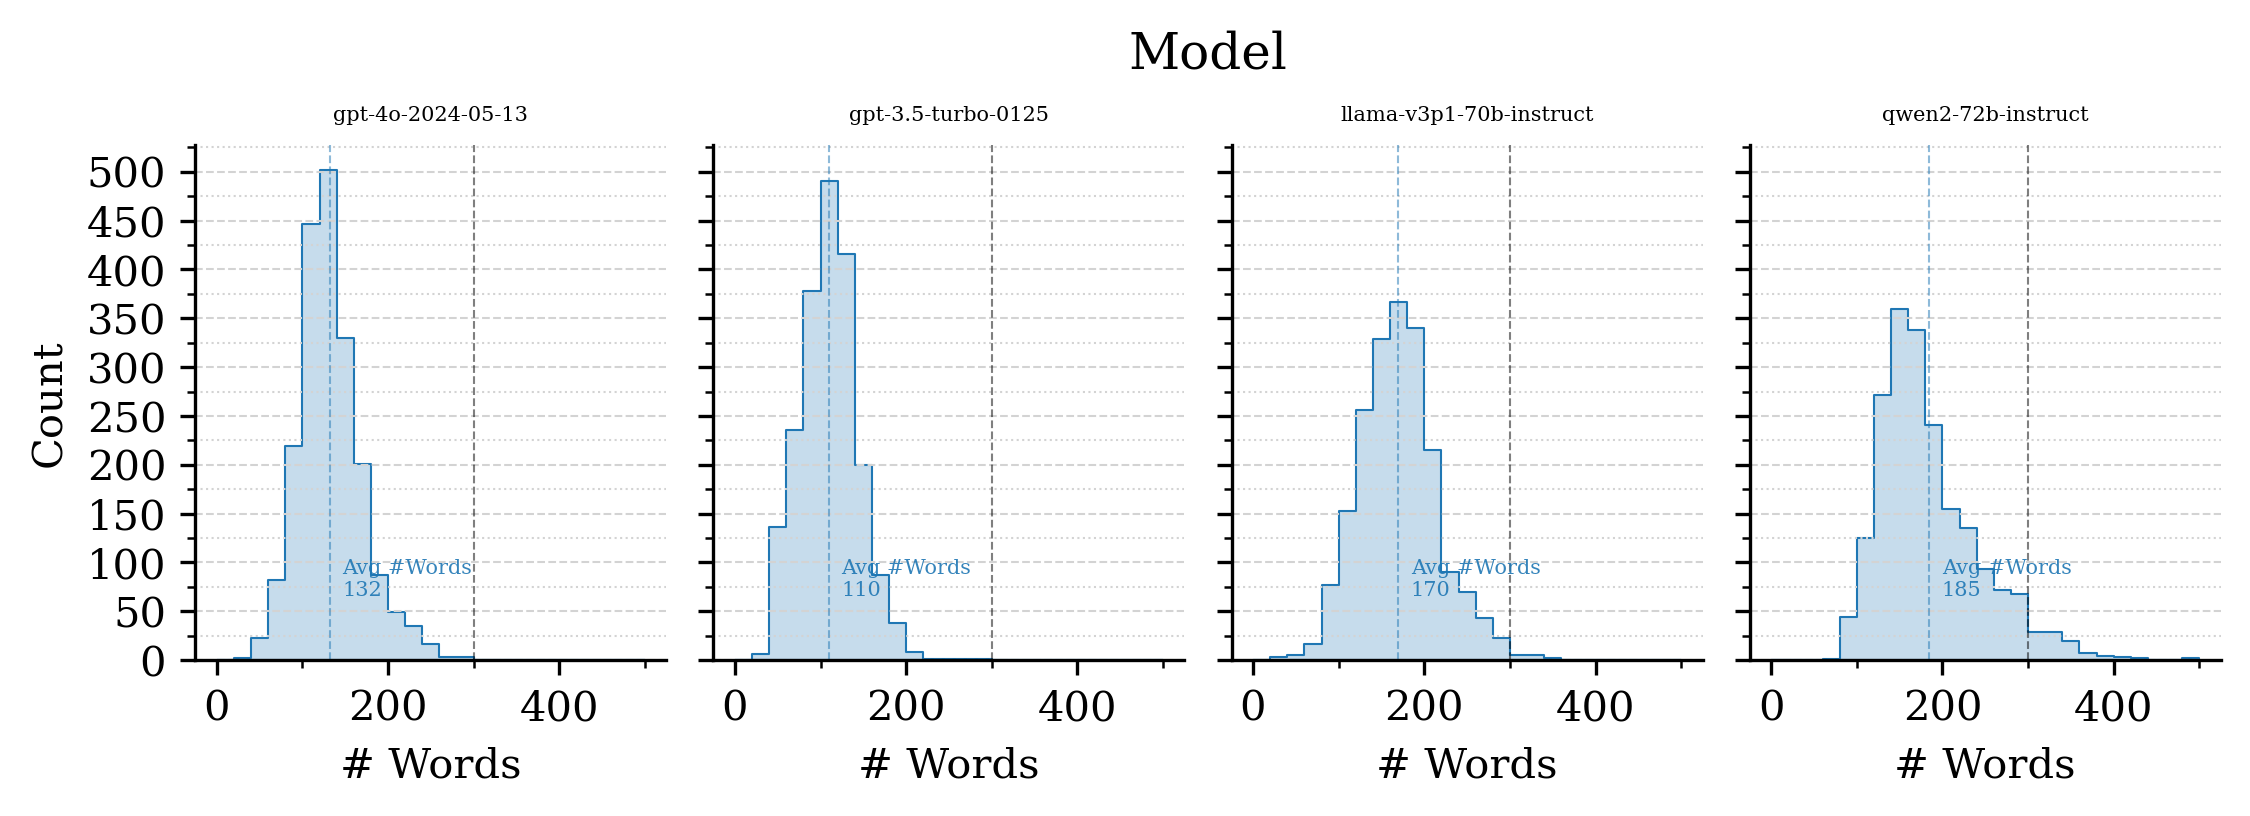

In [17]:
N_MODELS = length_analysis.model.nunique()
fig, axes = plt.subplots(1, N_MODELS, sharey=True, figsize=(FULL_WIDTH, COL_WIDTH*0.66), dpi=300)
fig.suptitle("Model")
# metric="nltk_num_words_no_punct"
metric = "nltk_num_words"

prompt_type = "shared"

for i, model in enumerate(length_analysis.model.unique()):
    canonic_model = model.rpartition("/")[-1]
    length_subset = length_analysis[length_analysis["model"] == canonic_model]
    length_subset = length_subset[length_subset["type"] ==prompt_type]
    sns.histplot(length_subset, x=metric, ax=axes[i], bins=25, binrange=(0, 500), element="step", fill=True, linewidth=0.5, alpha=0.25)
    axes[i].set_title(canonic_model, fontsize=5)
    axes[i].set_xlabel("# Words")

    axes[i].xaxis.set_minor_locator(MultipleLocator(100))

    axes[i].yaxis.set_minor_locator(MultipleLocator(25))
    axes[i].yaxis.set_major_locator(MultipleLocator(50))

    axes[i].grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
    axes[i].grid(axis='y', which="minor", linewidth=0.5, linestyle=':', color="lightgray")

    length_subset_mean = length_subset[metric].mean()
    color = sns.color_palette("tab10")[0]
    axes[i].axvline(x=300, color="black", linewidth=0.5, linestyle='--', alpha=0.5)
    axes[i].axvline(x=length_subset_mean, color=color, linewidth=0.5, linestyle='--', alpha=0.5)

    axes[i].annotate(f'Avg #Words\n{length_subset_mean:.0f}', xy=(length_subset_mean, 20), xytext=(3, 10),
                 textcoords='offset points', ha='left', va='bottom', fontsize=5, color=color, alpha=0.9)
    
    remove_axes(axes[i])

adjust(fig, wspace=0.1, top=0.8)

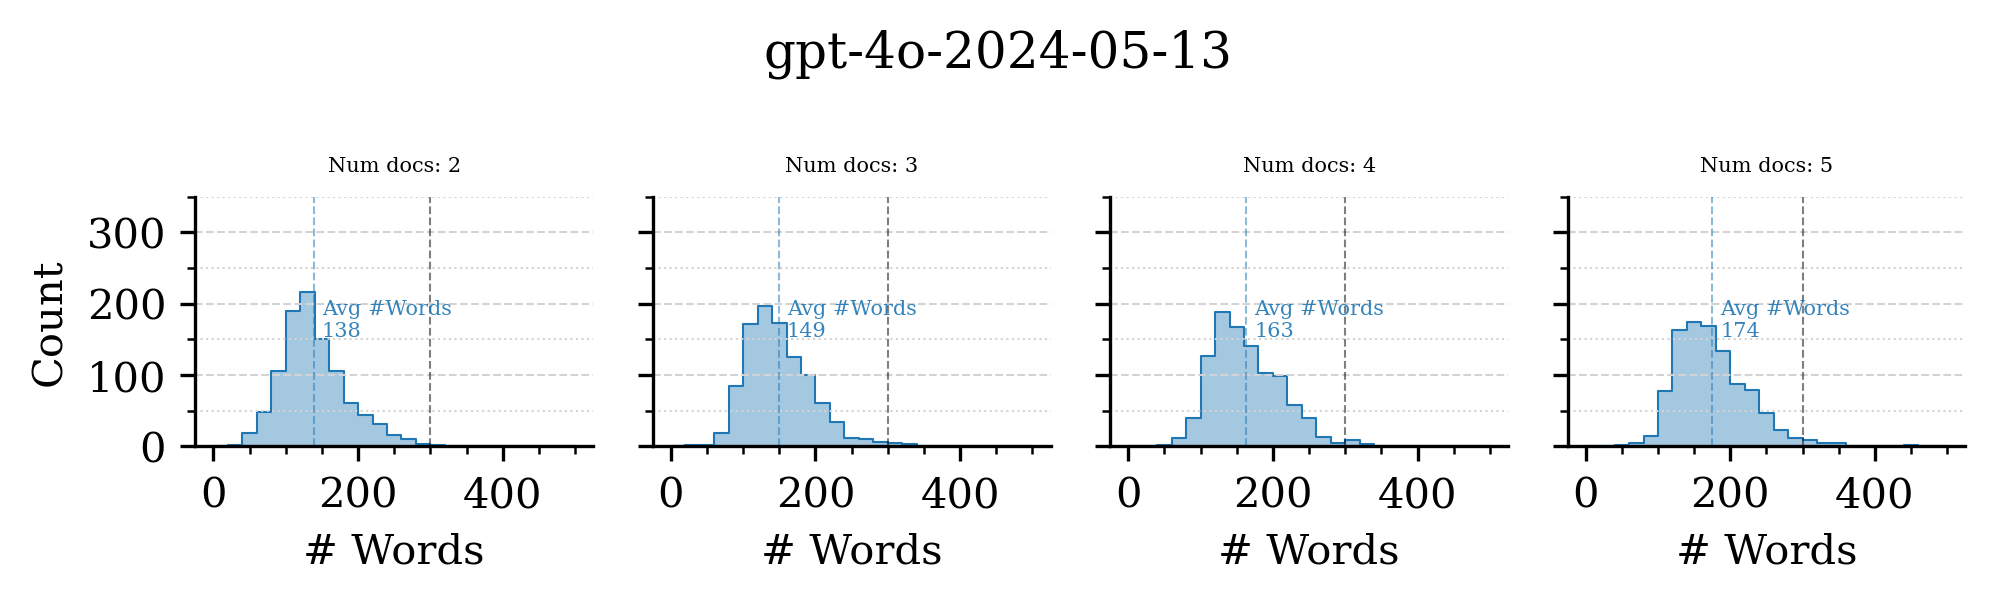

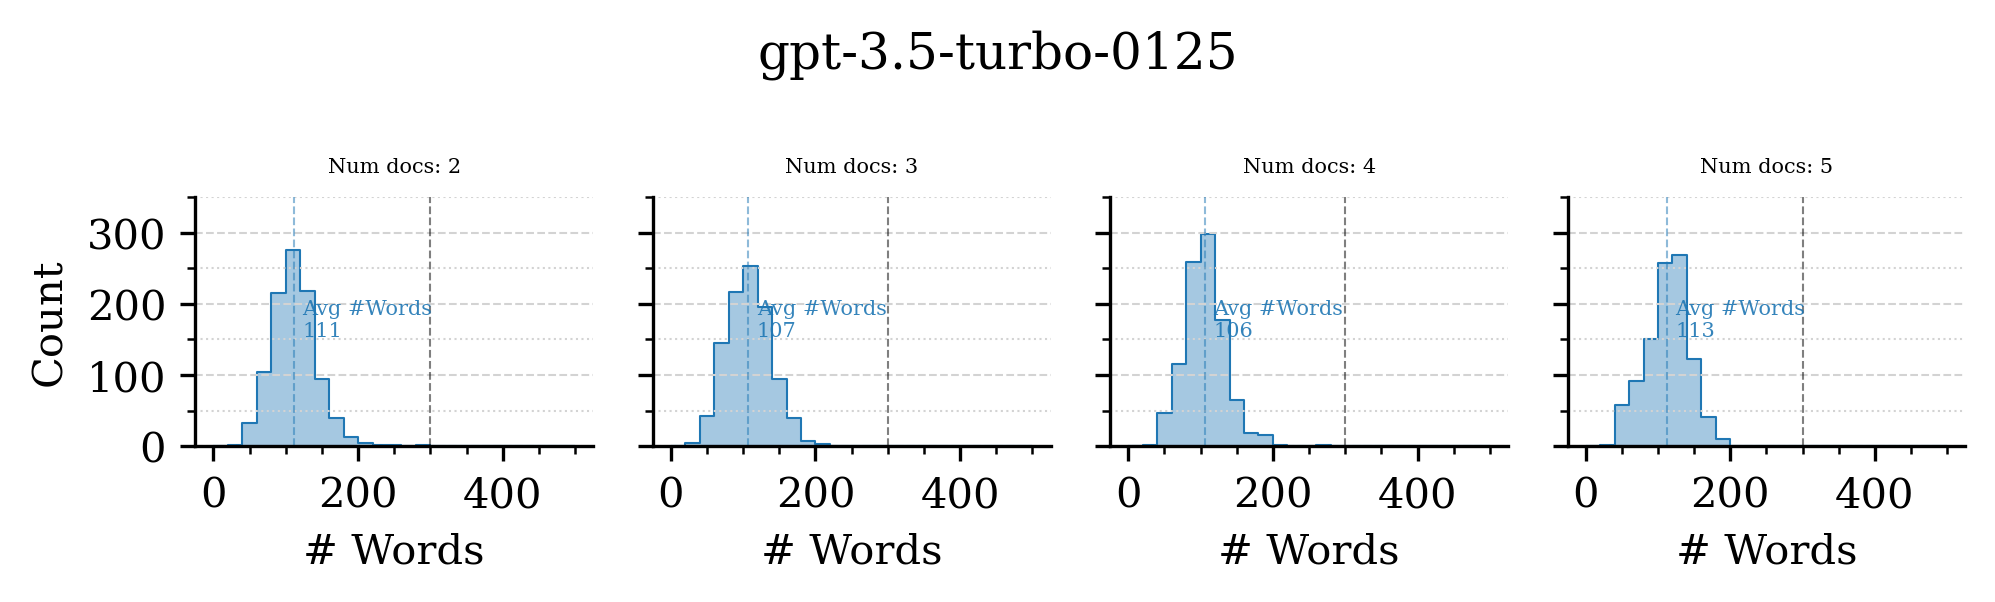

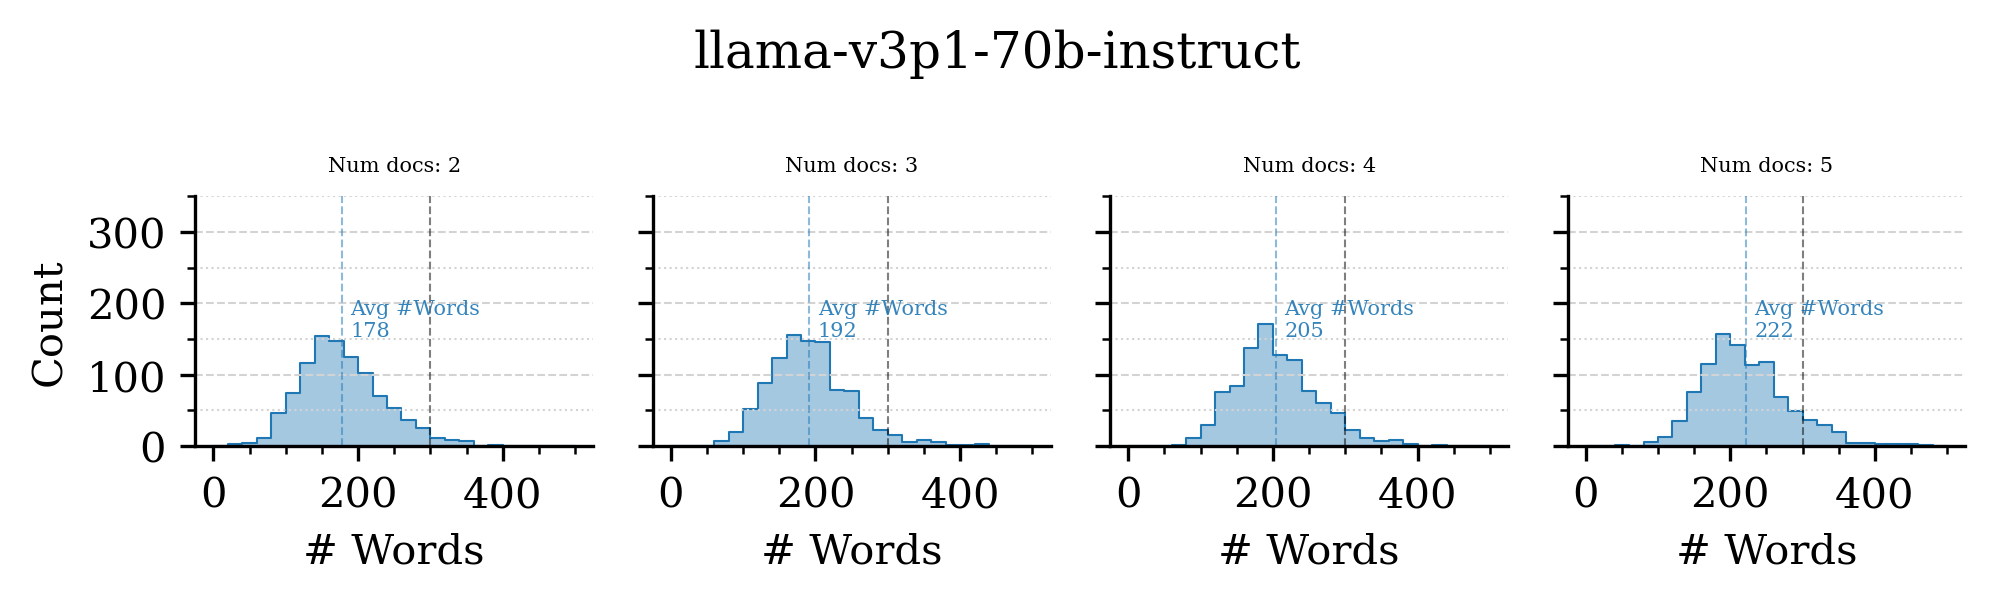

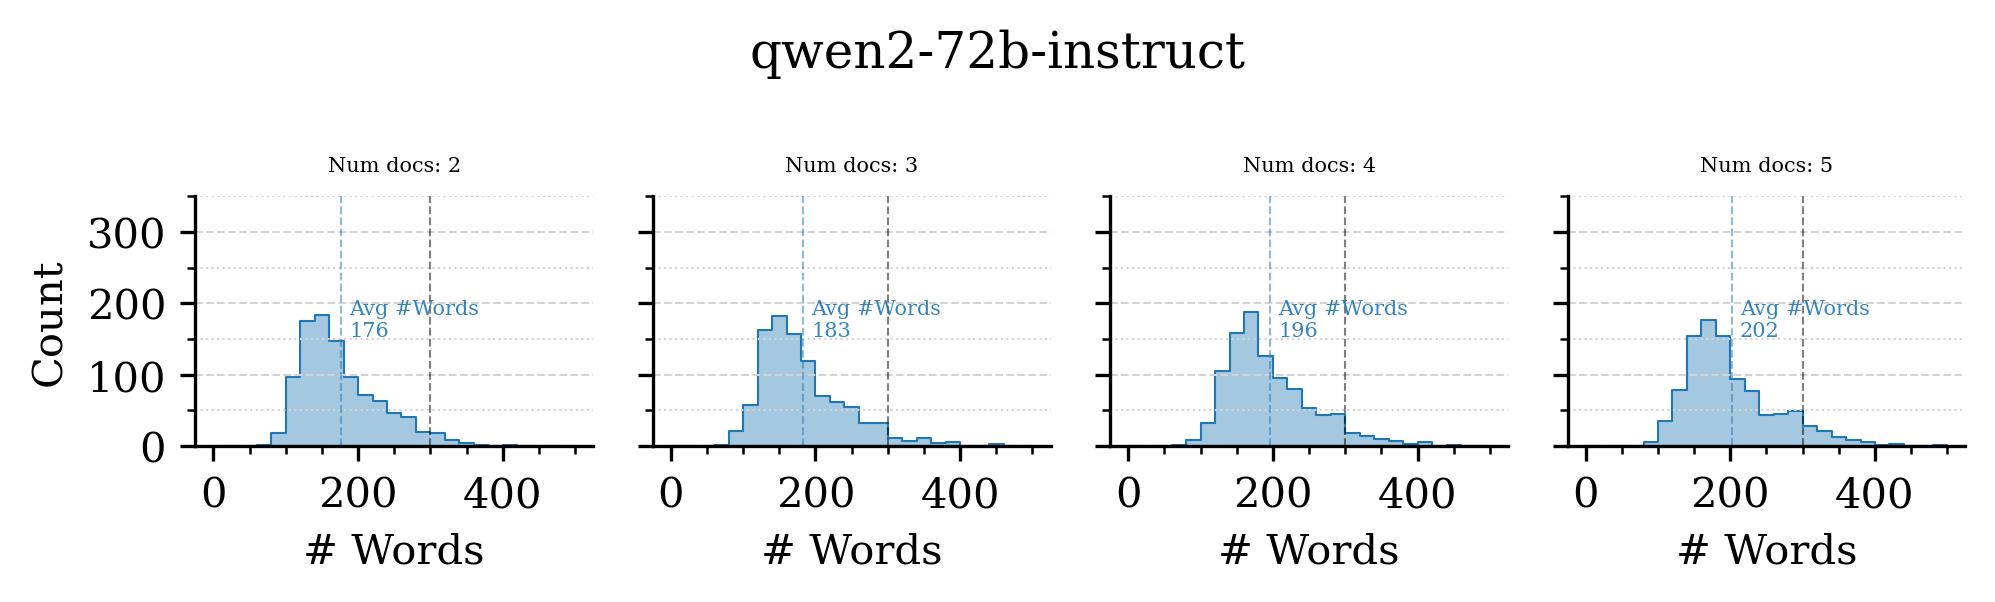

In [18]:
# metric="nltk_num_words_no_punct"
metric = "nltk_num_words"
for i, model in enumerate(length_analysis.model.unique()):
    canonic_model = model.rpartition("/")[-1]
    length_subset = length_analysis[length_analysis["model"] == canonic_model]

    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)
    fig.suptitle(canonic_model, fontsize=12)
    
    for i, comb in enumerate(COMBINATIONS):
        length_comb_subset = length_subset[length_subset["num_docs"] == comb]
        sns.histplot(length_comb_subset, x=metric, ax=axes[i], bins=25, binrange=(0, 500), element="step", fill=True, linewidth=0.5, alpha=0.4)
        axes[i].set_title(f"Num docs: {comb}", fontsize=5)
        axes[i].set_xlabel("# Words")
        axes[i].set_ylim((0, 350))

        axes[i].xaxis.set_minor_locator(MultipleLocator(50))
        axes[i].xaxis.set_major_locator(MultipleLocator(200))
        axes[i].yaxis.set_minor_locator(MultipleLocator(50))
        axes[i].yaxis.set_major_locator(MultipleLocator(100))
    
        axes[i].grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
        axes[i].grid(axis='y', which="minor", linewidth=0.5, linestyle=':', color="lightgray")
    
        length_subset_mean = length_comb_subset[metric].mean()
        color = sns.color_palette("tab10")[0]
        axes[i].axvline(x=300, color="black", linewidth=0.5, linestyle='--', alpha=0.5)
        axes[i].axvline(x=length_subset_mean, color=color, linewidth=0.5, linestyle='--', alpha=0.5)
    
        axes[i].annotate(f'Avg #Words\n{length_subset_mean:.0f}', xy=(length_subset_mean, 90), xytext=(2, 10),
                     textcoords='offset points', ha='left', va='bottom', fontsize=5, color=color, alpha=0.9)
        remove_axes(axes[i])
    fig.tight_layout()

    # adjust(fig)

Image saved in ../paper/images/lineplot/length__models.pdf


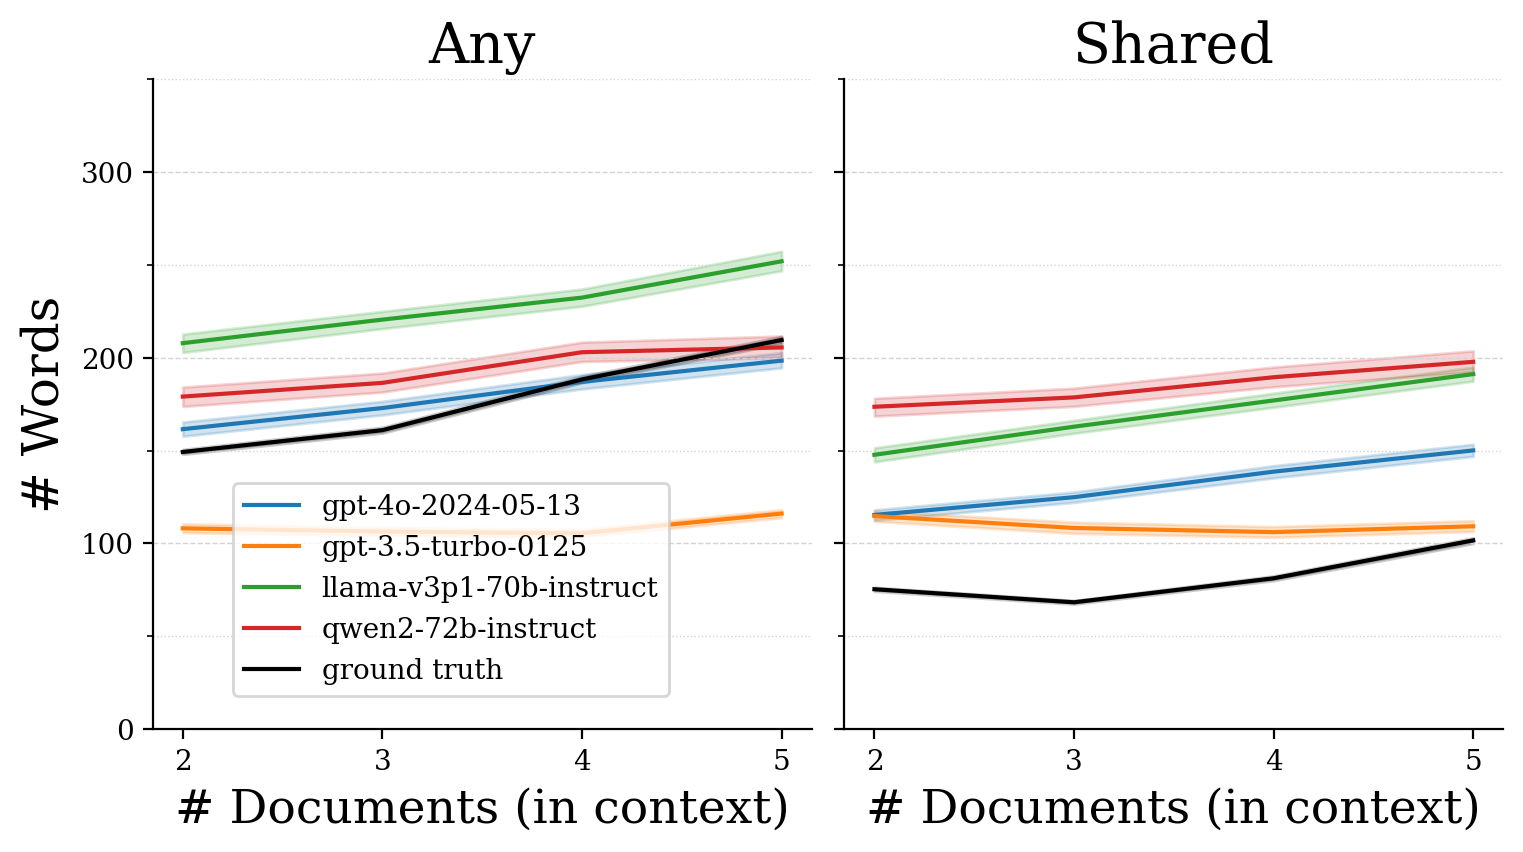

In [19]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, COL_WIDTH), dpi=200)

metric = "nltk_num_words"
ax=axes[0]
length_analysis_subtopic = length_analysis[length_analysis["type"] == "any"]
sns.lineplot(length_analysis_subtopic, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis[ground_length_analysis["type"] == "any"], x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylim((0, 350))
ax.set_ylabel("# Words", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=0.5, linestyle=':', color="lightgray")
ax.set_title("Any", fontsize=20)
ax.legend(loc="upper left", bbox_to_anchor=(0.1, 0.4), fontsize=10)

remove_axes(ax)

ax=axes[1]
length_analysis_subtopictrust = length_analysis[length_analysis["type"] == "shared"]
sns.lineplot(length_analysis_subtopictrust, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis[ground_length_analysis["type"] == "shared"], x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylabel("# Words", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=0.5, linestyle=':', color="lightgray")
ax.set_title("Shared", fontsize=20)
ax.get_legend().remove()

remove_axes(ax)
adjust(fig, wspace=0.05)
save_fig(fig, "lineplot/length__models.pdf")

Image saved in ../paper/images/lineplot/num_preds__models.pdf


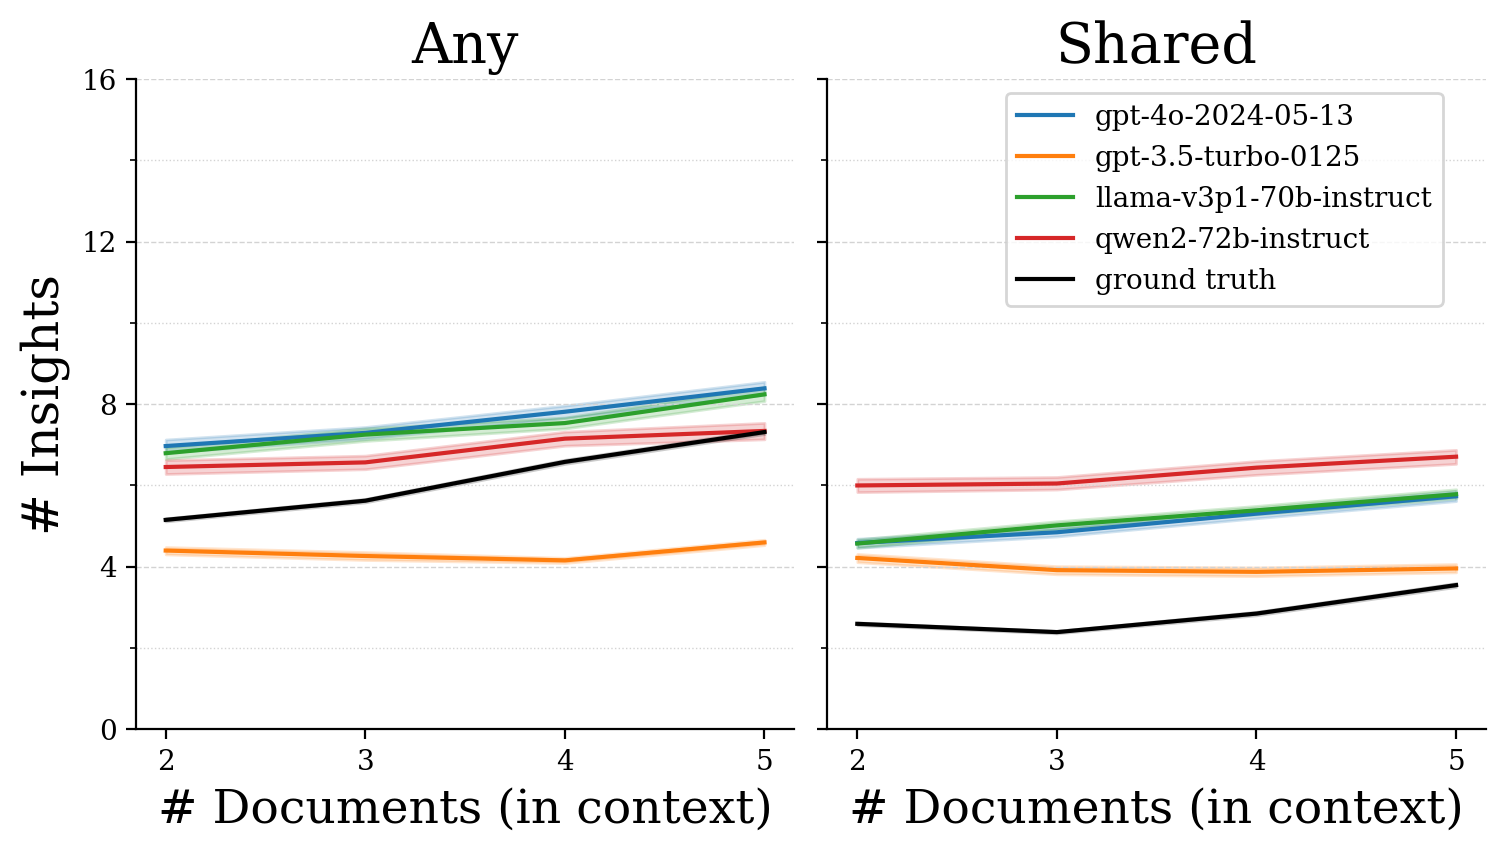

In [20]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, COL_WIDTH), dpi=200)

metric = "num_insights"
ax=axes[0]
length_analysis_subtopic = length_analysis[length_analysis["type"] == "any"]
sns.lineplot(length_analysis_subtopic, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis[ground_length_analysis["type"] == "any"], x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylim((0, 16))
ax.set_ylabel("# Insights", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(4))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=0.5, linestyle=':', color="lightgray")
ax.set_title("Any", fontsize=20)
ax.get_legend().remove()

remove_axes(ax)

ax=axes[1]
length_analysis_subtopictrust = length_analysis[length_analysis["type"] == "shared"]
sns.lineplot(length_analysis_subtopictrust, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis[ground_length_analysis["type"] == "shared"], x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylabel("# Words", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(4))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.grid(axis='y', which="minor", linewidth=0.5, linestyle=':', color="lightgray")
ax.set_title("Shared", fontsize=20)
ax.legend(loc="upper left", bbox_to_anchor=(0.25, 1), fontsize=10)

remove_axes(ax)
adjust(fig, wspace=0.05)
# TODO: update the figure depending on what models you used
save_fig(fig, "lineplot/num_preds__models.pdf")

# Per insight analysis

In [50]:
def get_number_of_words_ground_truth_insights(ground_truth_insights: list, insights: dict, tokenizer: callable):
    total, total_str = [], []
    for uuid in ground_truth_insights:
        string =  "- " + insights[uuid]["insight"]
        total.append(len(tokenizer(string)))
        total_str.append(string)
    return total, total_str 


ground_length_analysis_insight = defaultdict(list)
for combination in COMBINATIONS:
    filepaths = glob.glob(f'../data/SummHay/preprocessed/some_shared/combinations-{combination}/topic_news*__300.json', recursive=True)
    
    for fp in sorted(filepaths):        
        data = read_json(fp)
        insights = data["insights"]
        for ix, assign in enumerate(data["assignments"]):
            len_insights = get_number_of_words_ground_truth_insights(assign["ground_truth_insights_uuids"], insights, word_tokenize)
            for jx, (length, insight) in enumerate(zip(*len_insights)): 
                ground_length_analysis_insight["fp"].append(fp)
                ground_length_analysis_insight["type"].append("shared")

                ground_length_analysis_insight["num_docs"].append(combination)
                ground_length_analysis_insight["num_bullets"].append(len(len_insights[0]))

                ground_length_analysis_insight["response_id"].append(ix)
                ground_length_analysis_insight["bullet_id"].append(jx)
                ground_length_analysis_insight["bullet"].append(insight)    

                ground_length_analysis_insight["bullet__nltk_num_words"].append(length)

            
            # Determine the length of the insights related to a given subtopic
            
            all_uuids = assign["all_insights_uuids"]
            all_uuids_of_subtopic = [uuid for uuid in all_uuids if insights[uuid]["subtopic_id"] == assign["subtopic_uuid"]]
            len_insights = get_number_of_words_ground_truth_insights(all_uuids_of_subtopic, insights, word_tokenize)
            for jx, (length, insight) in enumerate(zip(*len_insights)): 
                ground_length_analysis_insight["fp"].append(fp)
                ground_length_analysis_insight["type"].append("any")

                ground_length_analysis_insight["num_docs"].append(combination)
                ground_length_analysis_insight["num_bullets"].append(len(len_insights[0]))

                ground_length_analysis_insight["response_id"].append(ix)
                ground_length_analysis_insight["bullet_id"].append(jx)
                ground_length_analysis_insight["bullet"].append(insight)    

                ground_length_analysis_insight["bullet__nltk_num_words"].append(length)
            
ground_length_analysis_insight = pd.DataFrame(ground_length_analysis_insight)
ground_length_analysis_insight.groupby(["type", "num_docs"]).count()

fp  num_bullets  response_id  bullet_id  bullet  \
type   num_docs                                                       
any    2          7727         7727         7727       7727    7727   
       3          8435         8435         8435       8435    8435   
       4          9868         9868         9868       9868    9868   
       5         10969        10969        10969      10969   10969   
shared 2          3889         3889         3889       3889    3889   
       3          3583         3583         3583       3583    3583   
       4          4268         4268         4268       4268    4268   
       5          5319         5319         5319       5319    5319   

                 bullet__nltk_num_words  
type   num_docs                          
any    2                           7727  
       3                           8435  
       4                           9868  
       5                          10969  
shared 2                           3889  
       3                           3583  
       4                           4268  
       5                           5319

In [51]:
MODELS = (
    "gpt-4o-2024-05-13",
    "gpt-3.5-turbo-0125",
    "accounts/fireworks/models/llama-v3-70b-instruct",
    "accounts/fireworks/models/mixtral-8x7b-instruct-hf",
    # "accounts/fireworks/models/llama-v3p1-70b-instruct",
)

length_analysis_insight = defaultdict(list)
for combination in COMBINATIONS:
    for model in MODELS:
        for prompt_type in ("subtopic", "subtopic_trustworthy"):
            filepaths = glob.glob(f'../outputs_length300/results_some_shared/{prompt_type}/SummHay__combinations-{combination}/{model}/topic_news*__300__examples0,50.json', recursive=True)
            for fp in sorted(filepaths):        
                data = read_json(fp)
                for ix, assign in enumerate(data["assignments"]):
                    pred_insights = bullet_processor(assign["response"])
                    for jx, ins in enumerate(pred_insights):
                        length_analysis_insight["fp"].append(fp)
                        length_analysis_insight["model"].append(model.rpartition("/")[-1])
                        if prompt_type == "subtopic":
                            length_analysis_insight["type"].append("any")
                        else:
                            length_analysis_insight["type"].append("shared")
                        length_analysis_insight["response_id"].append(ix)
                        length_analysis_insight["num_docs"].append(combination)
                        length_analysis_insight["num_bullets"].append(len(pred_insights))
                        length_analysis_insight["bullet_id"].append(jx)
                        length_analysis_insight["bullet"].append(ins)    
                        length_analysis_insight["bullet__nltk_num_words"].append(len(word_tokenize(ins)))

length_analysis_insight = pd.DataFrame(length_analysis_insight)
length_analysis_insight.groupby(["num_docs", "type"]).count()

fp  model  response_id  num_bullets  bullet_id  bullet  \
num_docs type                                                                
2        any      9748   9748         9748         9748       9748    9748   
         shared   7958   7958         7958         7958       7958    7958   
3        any     10006  10006        10006        10006      10006   10006   
         shared   7903   7903         7903         7903       7903    7903   
4        any      9425   9425         9425         9425       9425    9425   
         shared   7786   7786         7786         7786       7786    7786   
5        any      9495   9495         9495         9495       9495    9495   
         shared   7983   7983         7983         7983       7983    7983   

                 bullet__nltk_num_words  
num_docs type                            
2        any                       9748  
         shared                    7958  
3        any                      10006  
         shared                    7903  
4        any                       9425  
         shared                    7786  
5        any                       9495  
         shared                    7983

Image saved in ../paper/images/lineplot/num_words_per_insight__condition300words.pdf


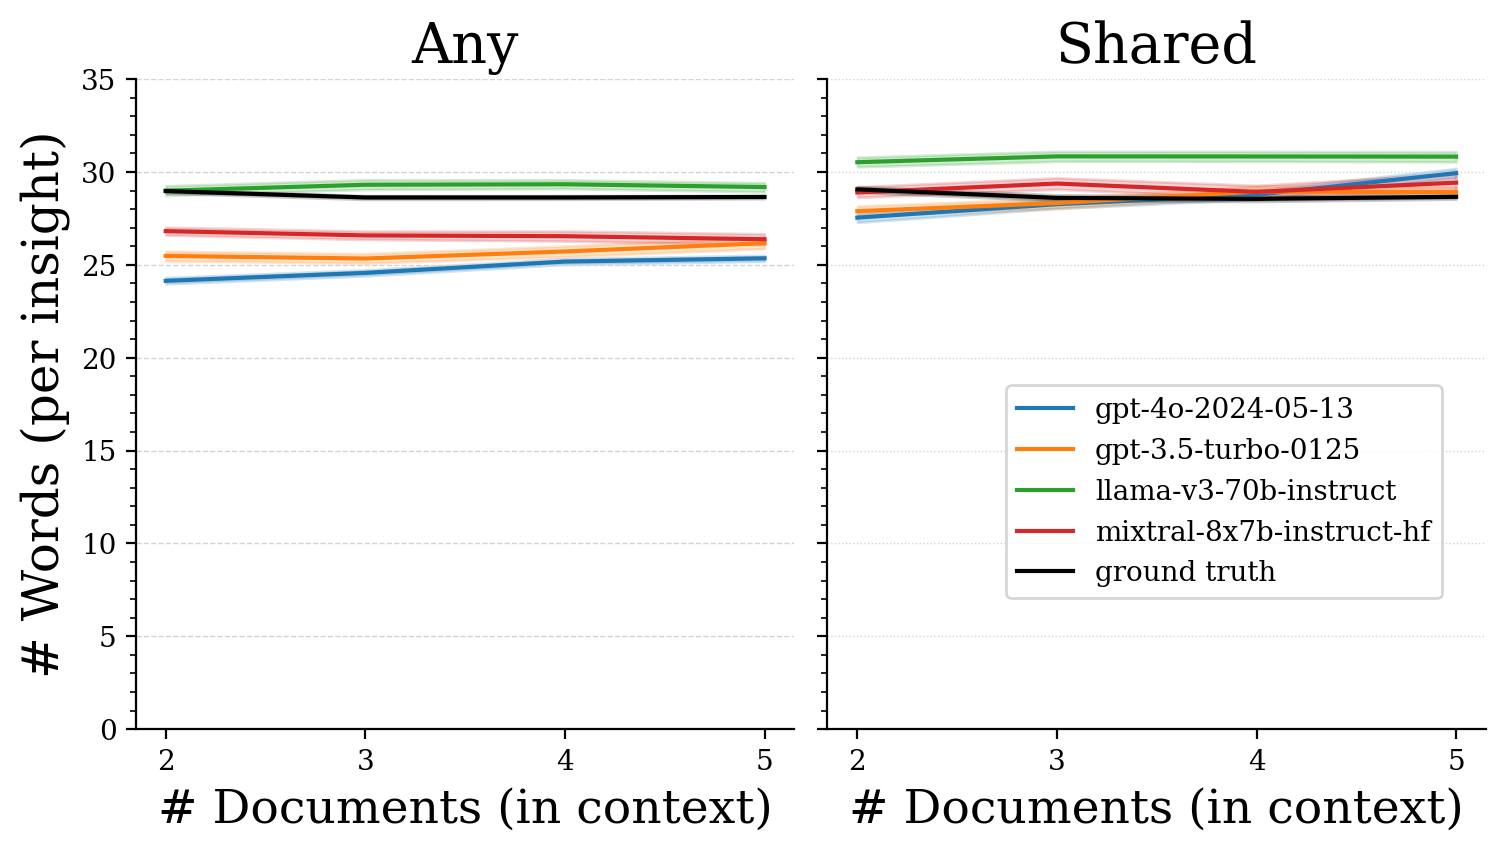

In [52]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, COL_WIDTH), dpi=200)

metric = "bullet__nltk_num_words"
ax=axes[0]
length_analysis_subtopic = length_analysis_insight[length_analysis_insight["type"] == "any"]
sns.lineplot(length_analysis_subtopic, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis_insight[ground_length_analysis_insight["type"] == "any"], x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylim((0, 35))
ax.set_ylabel("# Words (per insight)", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.set_title("Any", fontsize=20)
ax.get_legend().remove()

remove_axes(ax)

ax=axes[1]
length_analysis_insight_shared = length_analysis_insight[length_analysis_insight["type"] == "shared"]
sns.lineplot(length_analysis_insight_shared, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis_insight[ground_length_analysis_insight["type"] == "shared"], x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylabel("# Words (per insight)", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle=':', color="lightgray")
ax.set_title("Shared", fontsize=20)
ax.legend(loc="upper left", bbox_to_anchor=(0.25, 0.55), fontsize=10)

remove_axes(ax)
adjust(fig, wspace=0.05)
# TODO: update the figure depending on what models you used
save_fig(fig, "lineplot/num_words_per_insight__condition300words.pdf")

In [53]:
MODELS = (
    "gpt-4o-2024-05-13",
    "gpt-3.5-turbo-0125",
    # "accounts/fireworks/models/llama-v3-70b-instruct",
    "accounts/fireworks/models/llama-v3p1-70b-instruct",
    "accounts/fireworks/models/qwen2-72b-instruct",
    #"accounts/fireworks/models/llama-v3p1-8b-instruct",
    # "accounts/fireworks/models/gemma2-9b-it",
)
length_analysis_insight = defaultdict(list)
for combination in COMBINATIONS:
    for model in MODELS:
        for prompt_type in ("subtopic", "subtopic_trustworthy"):
            filepaths = glob.glob(f'../outputs/generate_summaries/results_some_shared/{prompt_type}/SummHay__combinations-{combination}/{model}/topic_news*__300__examples0,100.json', recursive=True)
            for fp in sorted(filepaths):        
                data = read_json(fp)
                for ix, assign in enumerate(data["assignments"]):
                    pred_insights = bullet_processor(assign["response"])
                    for jx, ins in enumerate(pred_insights):
                        length_analysis_insight["fp"].append(fp)
                        length_analysis_insight["model"].append(model.rpartition("/")[-1])
                        if prompt_type == "subtopic":
                            length_analysis_insight["type"].append("any")
                        else:
                            length_analysis_insight["type"].append("shared")
                        length_analysis_insight["response_id"].append(ix)
                        length_analysis_insight["num_docs"].append(combination)
                        length_analysis_insight["num_bullets"].append(len(pred_insights))
                        length_analysis_insight["bullet_id"].append(jx)
                        length_analysis_insight["bullet"].append(ins)    
                        length_analysis_insight["bullet__nltk_num_words"].append(len(word_tokenize(ins)))

length_analysis_insight = pd.DataFrame(length_analysis_insight)
length_analysis_insight.groupby(["num_docs", "type"]).count()

fp  model  response_id  num_bullets  bullet_id  bullet  \
num_docs type                                                                
2        any     12304  12304        12304        12304      12304   12304   
         shared   9681   9681         9681         9681       9681    9681   
3        any     12685  12685        12685        12685      12685   12685   
         shared   9911   9911         9911         9911       9911    9911   
4        any     13325  13325        13325        13325      13325   13325   
         shared  10499  10499        10499        10499      10499   10499   
5        any     14282  14282        14282        14282      14282   14282   
         shared  11088  11088        11088        11088      11088   11088   

                 bullet__nltk_num_words  
num_docs type                            
2        any                      12304  
         shared                    9681  
3        any                      12685  
         shared                    9911  
4        any                      13325  
         shared                   10499  
5        any                      14282  
         shared                   11088

Image saved in ../paper/images/lineplot/num_words_per_insight__nocondition300words.pdf


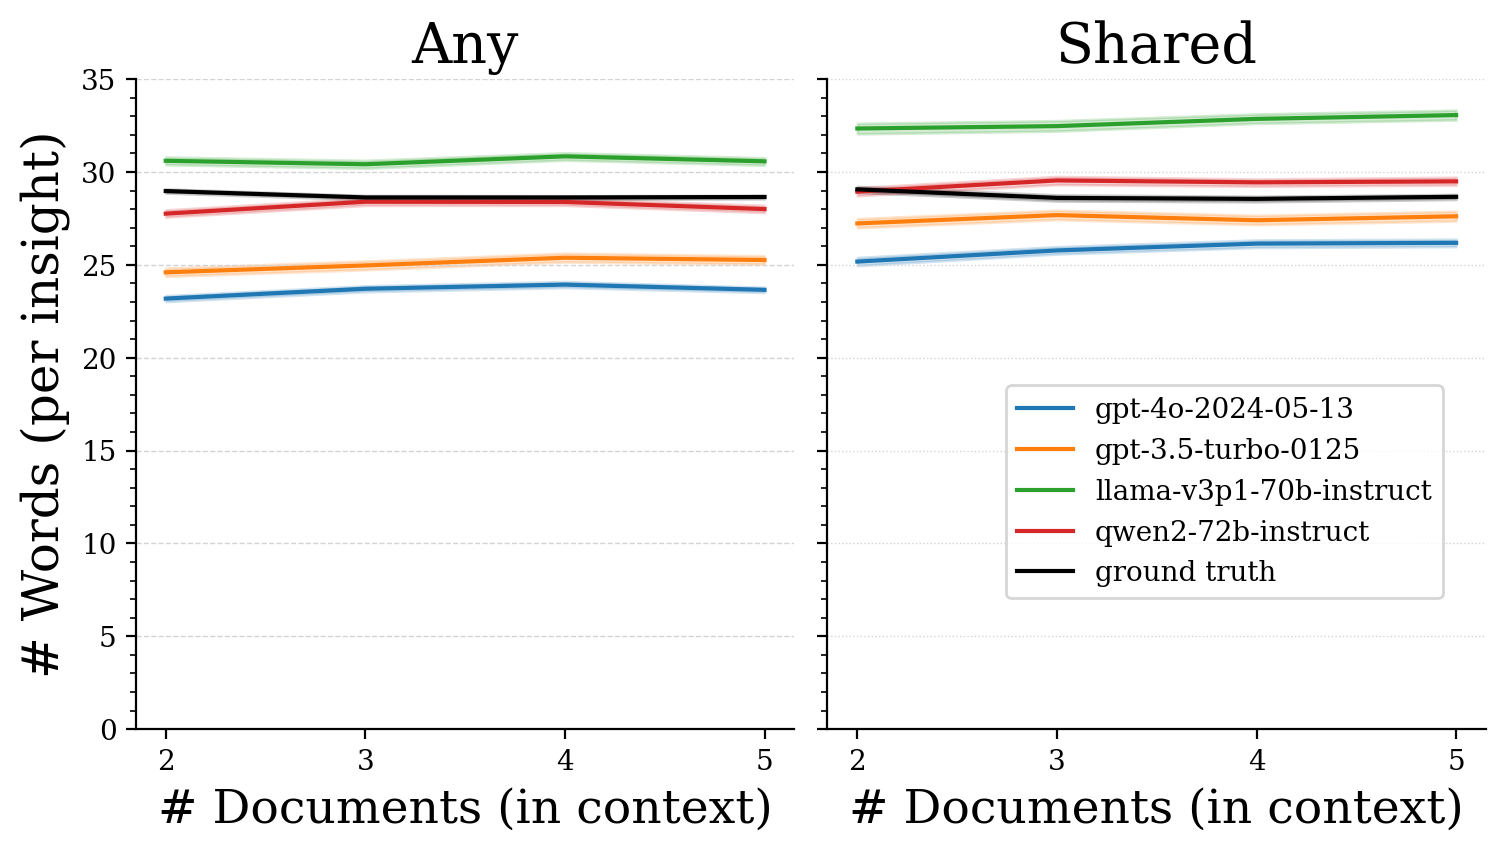

In [54]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, COL_WIDTH), dpi=200)

metric = "bullet__nltk_num_words"
ax=axes[0]
length_analysis_subtopic = length_analysis_insight[length_analysis_insight["type"] == "any"]
sns.lineplot(length_analysis_subtopic, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis_insight[ground_length_analysis_insight["type"] == "any"], x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylim((0, 35))
ax.set_ylabel("# Words (per insight)", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.set_title("Any", fontsize=20)
ax.get_legend().remove()

remove_axes(ax)

ax=axes[1]
length_analysis_insight_shared = length_analysis_insight[length_analysis_insight["type"] == "shared"]
sns.lineplot(length_analysis_insight_shared, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis_insight[ground_length_analysis_insight["type"] == "shared"], x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylabel("# Words (per insight)", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle=':', color="lightgray")
ax.set_title("Shared", fontsize=20)
ax.legend(loc="upper left", bbox_to_anchor=(0.25, 0.55), fontsize=10)

remove_axes(ax)
adjust(fig, wspace=0.05)
# TODO: update the figure depending on what models you used
save_fig(fig, "lineplot/num_words_per_insight__nocondition300words.pdf")

Image saved in ../paper/images/lineplot/num_insights__nocondition300words.pdf


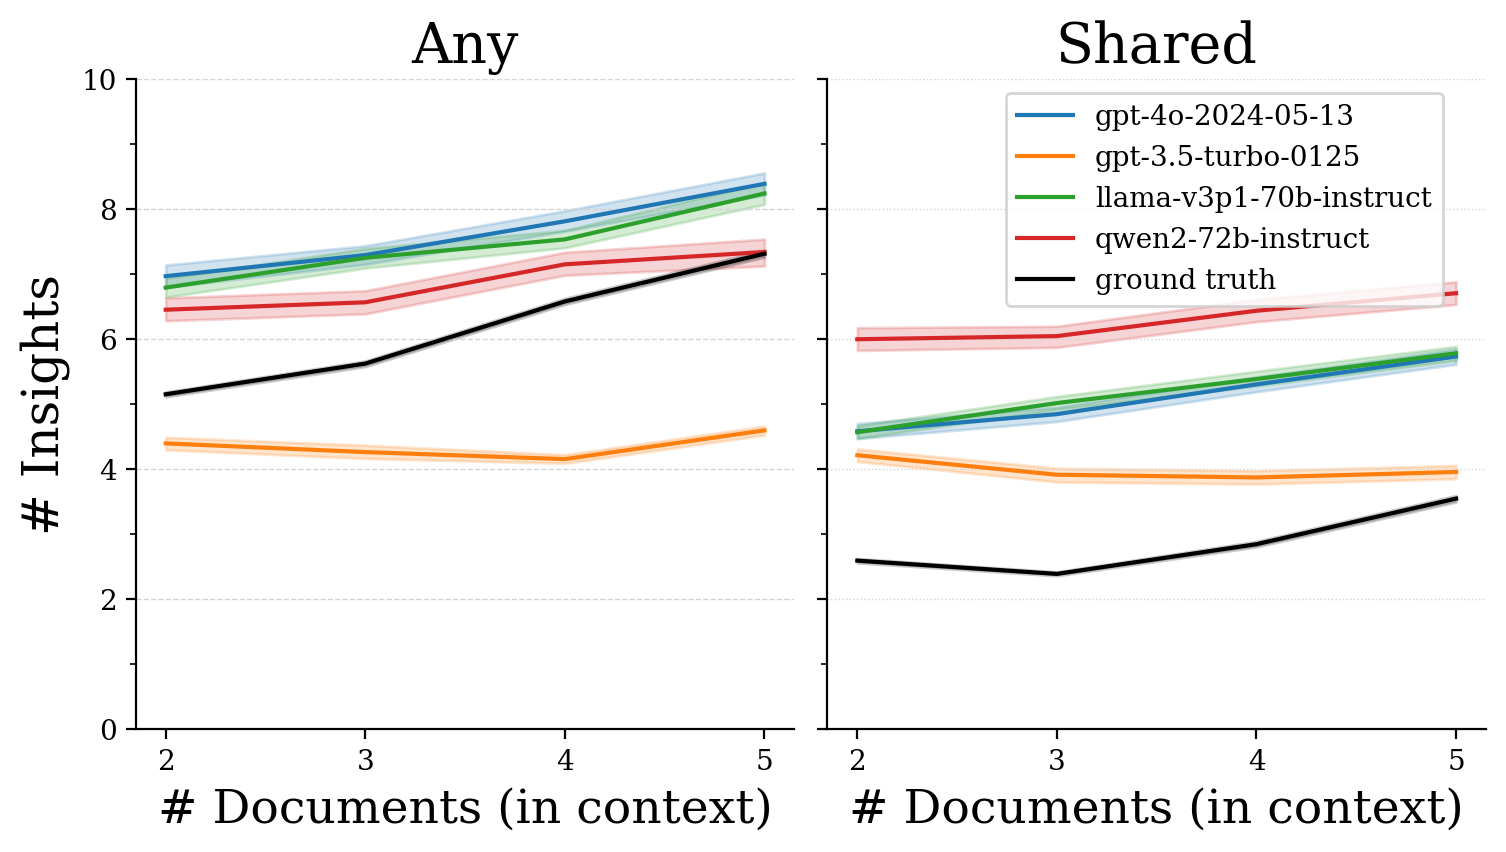

In [61]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(FULL_WIDTH, COL_WIDTH), dpi=200)

metric = "num_bullets"
ax=axes[0]
length_analysis_subtopic = length_analysis_insight[length_analysis_insight["type"] == "any"].drop_duplicates(["fp", "response_id"])
sns.lineplot(length_analysis_subtopic, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis_insight[ground_length_analysis_insight["type"] == "any"].drop_duplicates(["fp", "response_id"]), x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylim((0, 10))
ax.set_ylabel("# Insights", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
ax.set_title("Any", fontsize=20)
ax.get_legend().remove()

remove_axes(ax)

ax=axes[1]
length_analysis_insight_shared = length_analysis_insight[length_analysis_insight["type"] == "shared"].drop_duplicates(["fp", "response_id"])
sns.lineplot(length_analysis_insight_shared, x="num_docs", y=metric, hue="model", ax=ax)
sns.lineplot(ground_length_analysis_insight[ground_length_analysis_insight["type"] == "shared"].drop_duplicates(["fp", "response_id"]), x="num_docs", y=metric, color="black", label="ground truth", ax=ax)

ax.set_ylabel("# Insights", fontsize=18)
ax.set_xlabel("# Documents (in context)", fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.grid(axis='y', which="major", linewidth=0.5, linestyle=':', color="lightgray")
ax.set_title("Shared", fontsize=20)
ax.legend(loc="upper left", bbox_to_anchor=(0.25, 1.), fontsize=10)

remove_axes(ax)
adjust(fig, wspace=0.05)
# TODO: update the figure depending on what models you used
save_fig(fig, "lineplot/num_insights__nocondition300words.pdf")

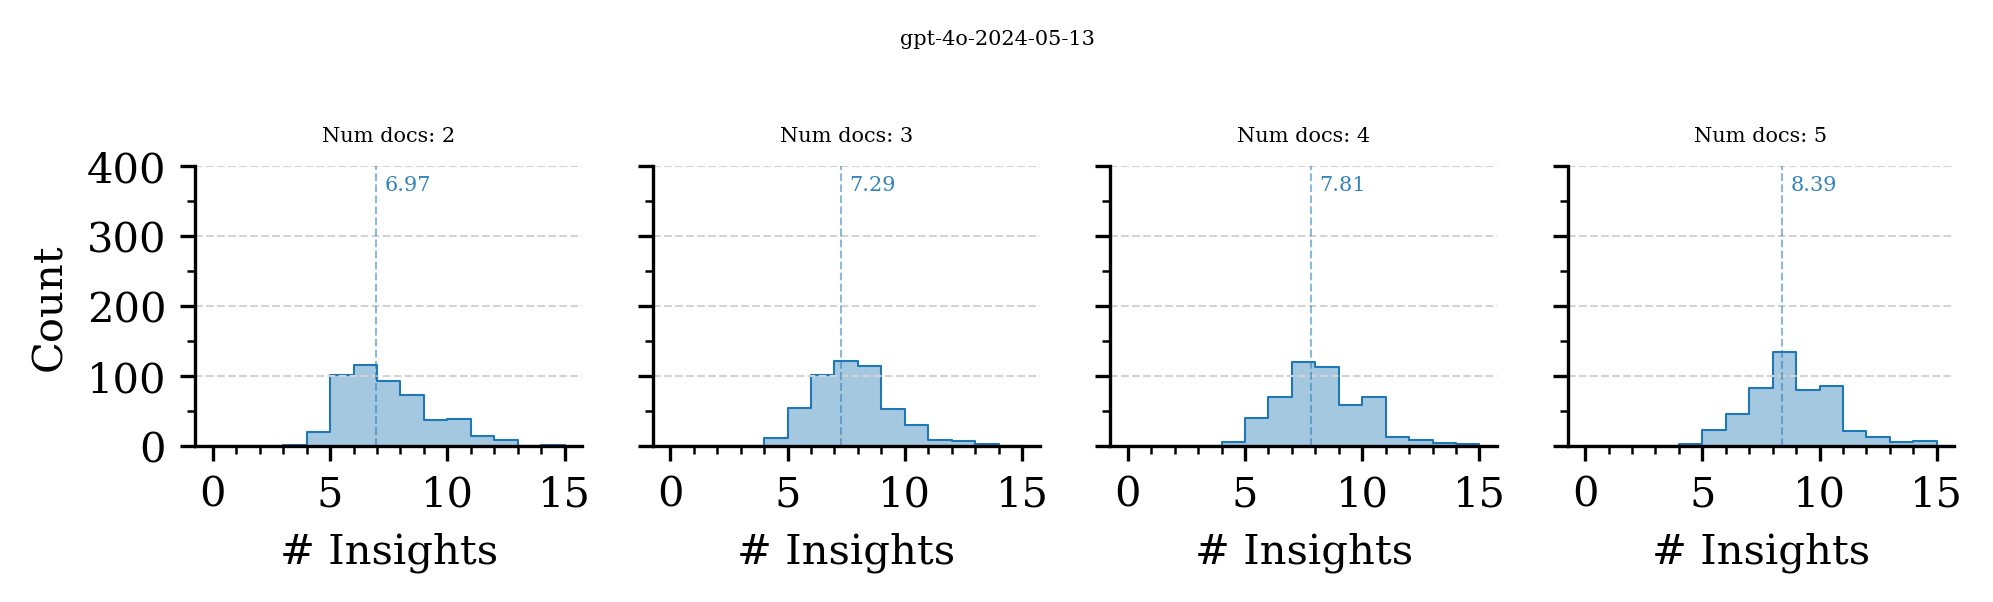

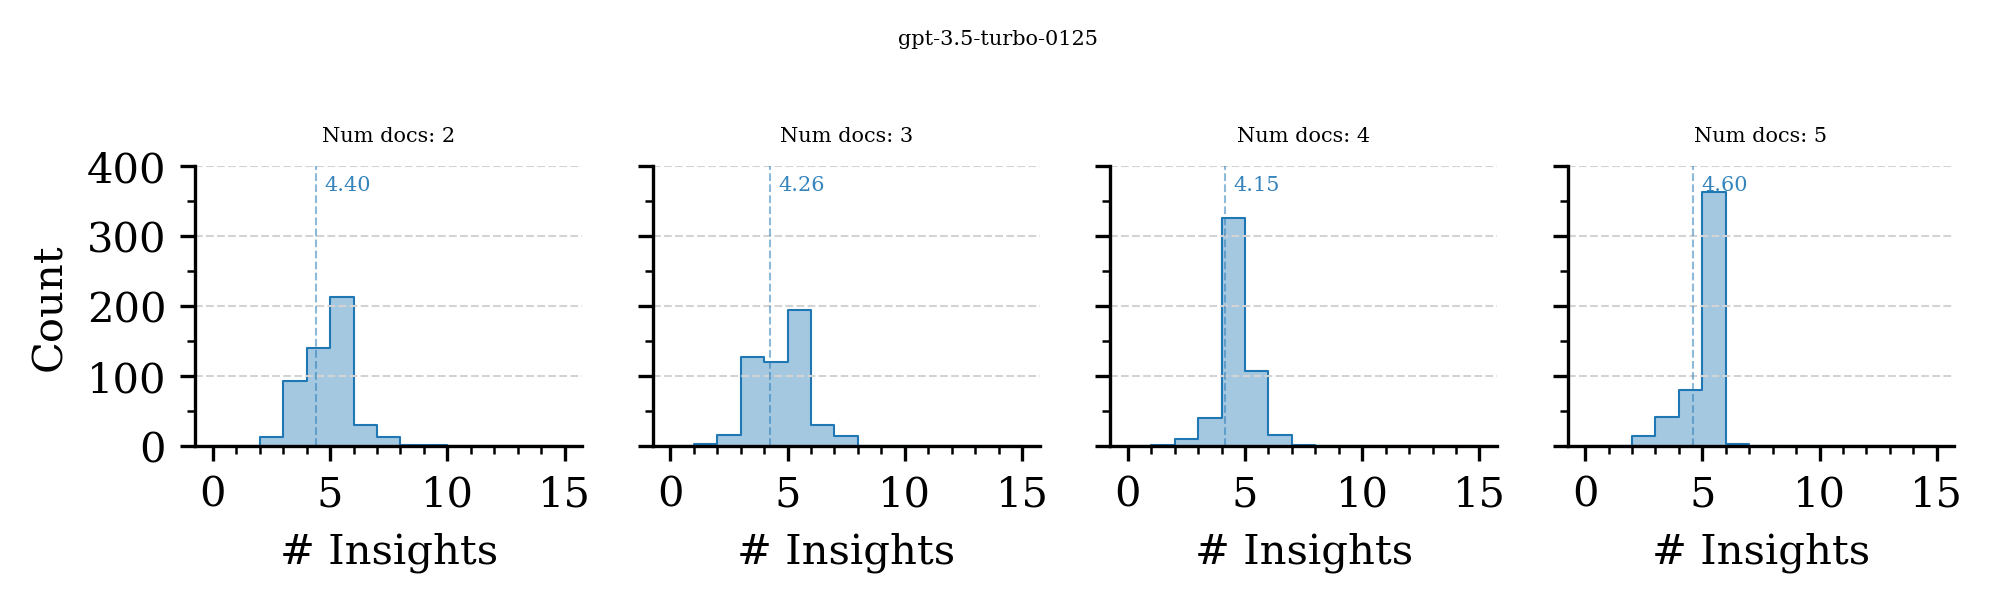

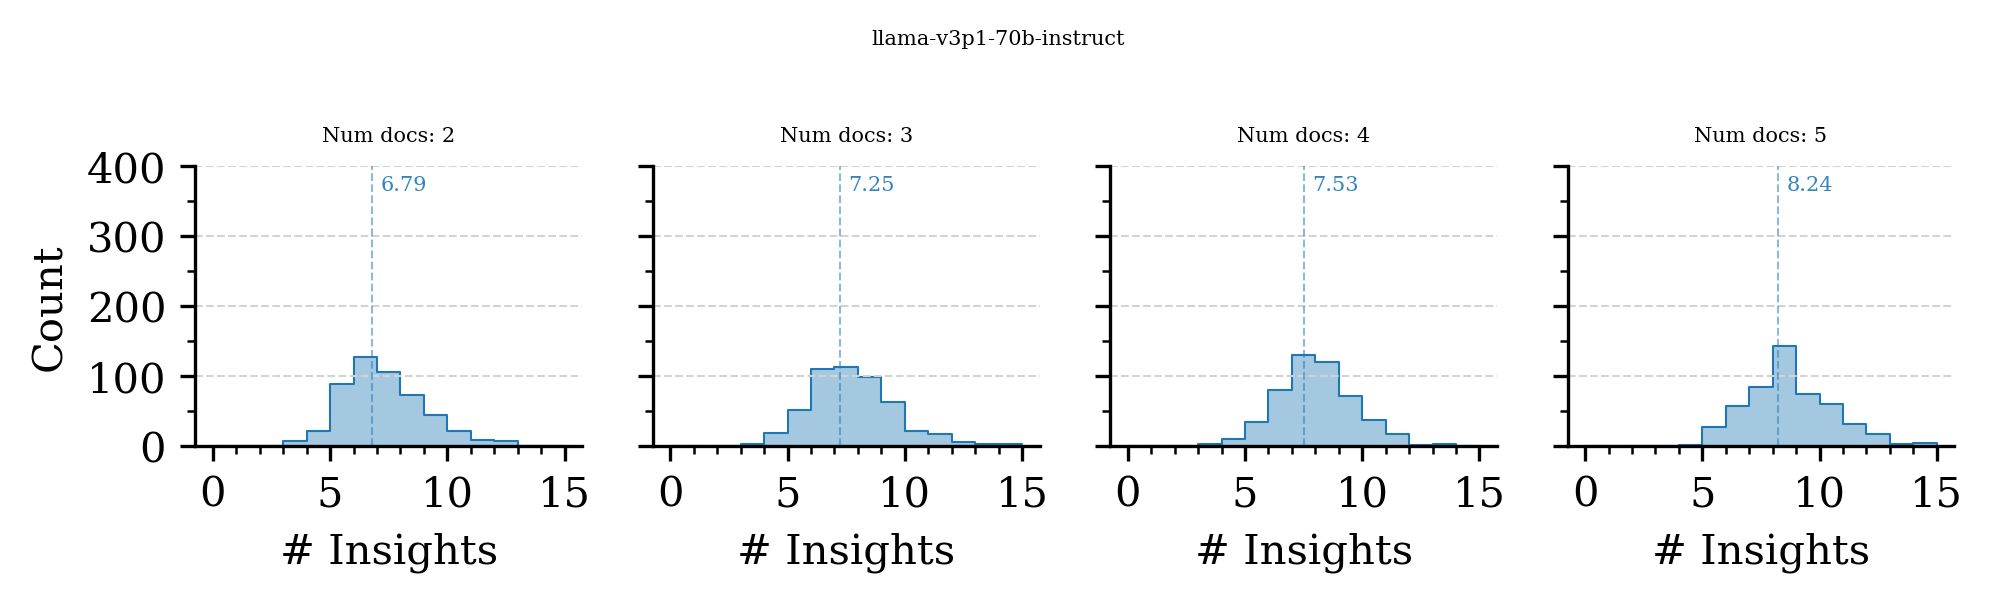

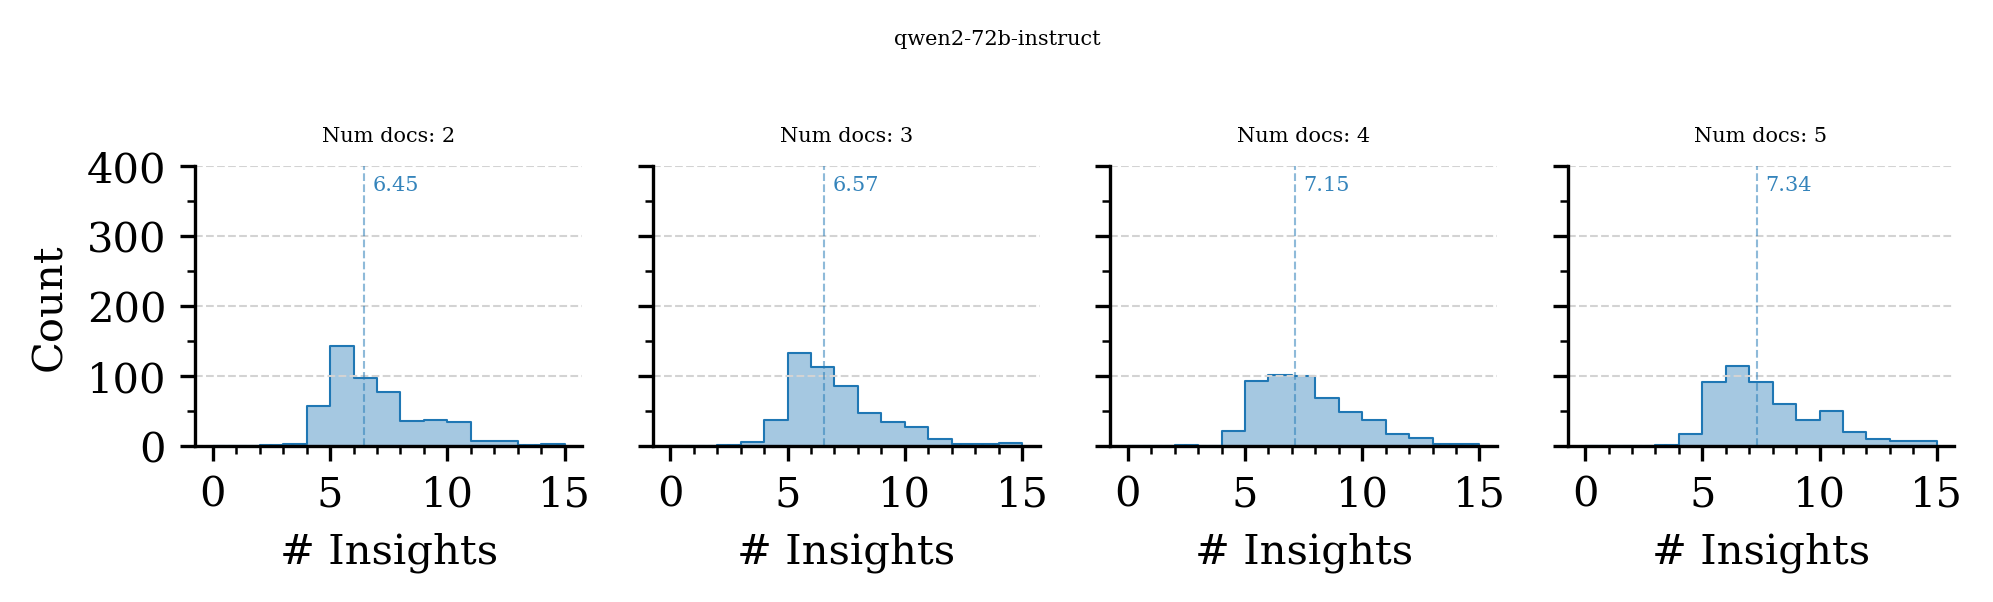

In [79]:
# metric="nltk_num_words_no_punct"
length_analysis_subtopic = length_analysis_insight[length_analysis_insight["type"] == "any"].drop_duplicates(["fp", "response_id"])

metric = "num_bullets"
for i, model in enumerate(length_analysis_subtopic.model.unique()):
    canonic_model = model.rpartition("/")[-1]
    length_subset = length_analysis_subtopic[length_analysis_subtopic["model"] == canonic_model]

    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(FULL_WIDTH, 2), dpi=300)
    fig.suptitle(canonic_model, fontsize=5)
    
    for i, comb in enumerate(COMBINATIONS):
        length_comb_subset = length_subset[length_subset["num_docs"] == comb]
        sns.histplot(length_comb_subset, x=metric, ax=axes[i], bins=15, binrange=(0, 15), element="step", fill=True, linewidth=0.5, alpha=0.4)
        axes[i].set_title(f"Num docs: {comb}", fontsize=5)
        axes[i].set_xlabel("# Insights")
        axes[i].set_ylim((0, 400))

        axes[i].xaxis.set_minor_locator(MultipleLocator(1))
        axes[i].xaxis.set_major_locator(MultipleLocator(5))
        axes[i].yaxis.set_minor_locator(MultipleLocator(50))
        axes[i].yaxis.set_major_locator(MultipleLocator(100))
        axes[i].grid(axis='y', which="major", linewidth=0.5, linestyle='--', color="lightgray")
    
        length_subset_mean = length_comb_subset[metric].mean()
        color = sns.color_palette("tab10")[0]

        axes[i].axvline(x=length_subset_mean, color=color, linewidth=0.5, linestyle='--', alpha=0.5)
        axes[i].annotate(f'{length_subset_mean:.2f}', xy=(length_subset_mean, 300), xytext=(2, 10),
                     textcoords='offset points', ha='left', va='bottom', fontsize=5, color=color, alpha=0.9)
        
        remove_axes(axes[i])
    fig.tight_layout()
    # adjust(fig)